**KAIBURR ASSESSMENT**              

                                                       

                                                                  

**6.DATA SCIENCE**


**Perform a Text Classification on consumer complaint dataset**

**NAME : JEYANTHI S**

**REG NO:19MID0131**

**Importing packages and loading data**

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import randint
import seaborn as sns # used for plot interactive graph.
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [ ]:
df = pd.read_csv('https://files.consumerfinance.gov/ccdb/complaints.csv')
df.shape

(4065103, 18)

**Exploratory Data Analysis (EDA) and Feature Engineering**

In [ ]:
df.head(2).T # Columns are shown in rows for easy reading

,0,1
Date received,2023-09-04,2023-09-06
Product,"Money transfer, virtual currency, or money ser...",Debt collection
Sub-product,Mobile or digital wallet,Other debt
Issue,Trouble accessing funds in your mobile or digi...,Attempts to collect debt not owed
Sub-issue,NaN,Debt was result of identity theft
Consumer complaint narrative,NaN,NaN
Company public response,NaN,Company believes the complaint is the result o...
Company,"Paypal Holdings, Inc","CCS Financial Services, Inc."
State,NC,FL
ZIP code,27587,33032


In [ ]:
# Create a new dataframe with two columns
df1 = df[['Product', 'Consumer complaint narrative']].copy()

# Remove missing values (NaN)
df1 = df1[pd.notnull(df1['Consumer complaint narrative'])]

# Renaming second column for a simpler name
df1.columns = ['Product', 'Consumer_complaint']

df1.shape

(1472203, 2)

In [ ]:
# Percentage of complaints with text
total = df1['Consumer_complaint'].notnull().sum()
round((total/len(df)*100),1)

36.2

In [ ]:
pd.DataFrame(df.Product.unique()).values

array([['Money transfer, virtual currency, or money service'],
       ['Debt collection'],
       ['Checking or savings account'],
       ['Credit reporting or other personal consumer reports'],
       ['Mortgage'],
       ['Credit card'],
       ['Vehicle loan or lease'],
       ['Credit reporting, credit repair services, or other personal consumer reports'],
       ['Student loan'],
       ['Payday loan, title loan, personal loan, or advance loan'],
       ['Credit card or prepaid card'],
       ['Consumer Loan'],
       ['Prepaid card'],
       ['Bank account or service'],
       ['Payday loan, title loan, or personal loan'],
       ['Debt or credit management'],
       ['Credit reporting'],
       ['Payday loan'],
       ['Money transfers'],
       ['Other financial service'],
       ['Virtual currency']], dtype=object)

In [ ]:
# Because the computation is time consuming (in terms of CPU), the data was sampled
df2 = df1.sample(10000, random_state=1).copy()

In [ ]:
# Renaming categories
df2.replace({'Product':
             {'Credit reporting, credit repair services, or other personal consumer reports':
              'Credit reporting, repair, or other',
              'Credit reporting': 'Credit reporting, repair, or other',
             'Credit card': 'Credit card or prepaid card',
             'Prepaid card': 'Credit card or prepaid card',
             'Payday loan': 'Payday loan, title loan, or personal loan',
             'Money transfer': 'Money transfer, virtual currency, or money service',
             'Virtual currency': 'Money transfer, virtual currency, or money service'}},
            inplace= True)

In [ ]:
pd.DataFrame(df2.Product.unique())

,0
0,"Credit reporting, repair, or other"
1,Mortgage
2,Checking or savings account
3,Credit card or prepaid card
4,Debt collection
5,"Money transfer, virtual currency, or money ser..."
6,"Payday loan, title loan, or personal loan"
7,Student loan
8,Consumer Loan
9,Vehicle loan or lease


In [ ]:
# Create a new column 'category_id' with encoded categories
df2['category_id'] = df2['Product'].factorize()[0]
category_id_df = df2[['Product', 'category_id']].drop_duplicates()


# Dictionaries for future use
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Product']].values)

# New dataframe
print(df2)


                                    Product  \
337270   Credit reporting, repair, or other   
814826   Credit reporting, repair, or other   
1157572  Credit reporting, repair, or other   
589205                             Mortgage   
2863449         Checking or savings account   
...                                     ...   
3409083  Credit reporting, repair, or other   
2756499  Credit reporting, repair, or other   
3392408  Credit reporting, repair, or other   
326256   Credit reporting, repair, or other   
1258628                     Debt collection   

                                        Consumer_complaint  category_id  
337270   The date of my first letter was XXXX. I sent a...            0  
814826   I was XXXX and my ID and social security card ...            0  
1157572  I'm really not sure what happened. I have mail...            0  
589205   I was impacted by hurricane Irma and then Mich...            1  
2863449  I am a XXXX XXXX  XXXX by trade. \n\nAt the en...       

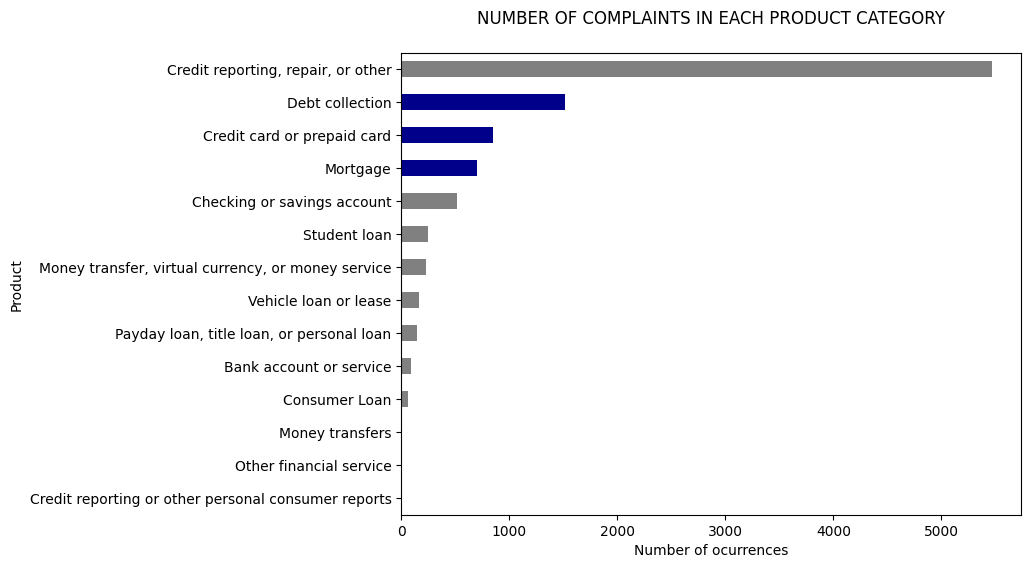

In [ ]:
fig = plt.figure(figsize=(8,6))
colors = ['grey','grey','grey','grey','grey','grey','grey','grey','grey',
    'grey','darkblue','darkblue','darkblue']
df2.groupby('Product').Consumer_complaint.count().sort_values().plot.barh(
    ylim=0, color=colors, title= 'NUMBER OF COMPLAINTS IN EACH PRODUCT CATEGORY\n')
plt.xlabel('Number of ocurrences', fontsize = 10);

**Text Preprocessing**

In [ ]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,
                        ngram_range=(1, 2),
                        stop_words='english')

# We transform each complaint into a vector
features = tfidf.fit_transform(df2.Consumer_complaint).toarray()

labels = df2.category_id

print("Each of the %d complaints is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 10000 complaints is represented by 26339 features (TF-IDF score of unigrams and bigrams)


In [ ]:
def function(train):
    comment_words = ""
    for i in train['Product']:
        val = str(i)
        tokens = val.split()
        for k in range(len(tokens)):
            tokens[k] = tokens[k].lower()
        comment_words += " ".join(tokens)+" "
    return comment_words

In [ ]:
def plot_wordcloud(train):
    from wordcloud import WordCloud, STOPWORDS
    stopwords = set(STOPWORDS)
    comment_words = function(train)
    wordcloud = WordCloud(width=400,
                      height=330,
                      max_words=150,
                      colormap='tab20c',
                      stopwords=stopwords,
                      collocations=True).generate_from_text(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

In [ ]:
temp = df2

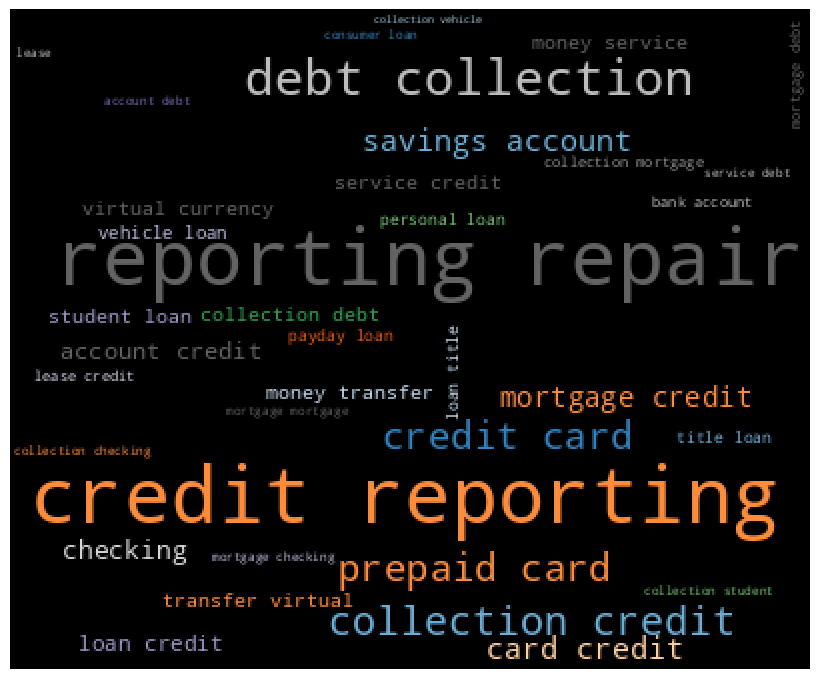

In [ ]:
plot_wordcloud(temp)

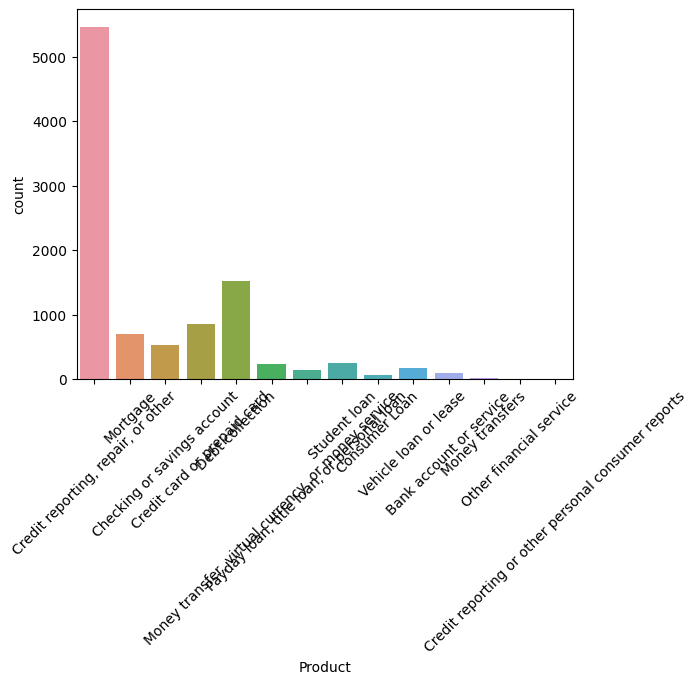

In [ ]:
sns.countplot(data=df2,x="Product")
plt.xticks(rotation=45)
plt.show()

In [ ]:
N = 3
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("\n==> %s:" %(Product))
  print("  * Most Correlated Unigrams are: %s" %(', '.join(unigrams[-N:])))
  print("  * Most Correlated Bigrams are: %s" %(', '.join(bigrams[-N:])))


==> Bank account or service:
  * Most Correlated Unigrams are: cd, stocks, promotion
  * Most Correlated Bigrams are: checking account, xxxx 2015, posting xxxx

==> Checking or savings account:
  * Most Correlated Unigrams are: deposited, overdraft, bank
  * Most Correlated Bigrams are: overdraft fees, savings account, checking account

==> Consumer Loan:
  * Most Correlated Unigrams are: vehicle, car, motor
  * Most Correlated Bigrams are: title loan, chrysler capital, car car

==> Credit card or prepaid card:
  * Most Correlated Unigrams are: express, amex, card
  * Most Correlated Bigrams are: use card, american express, credit card

==> Credit reporting or other personal consumer reports:
  * Most Correlated Unigrams are: usc, treat, 166b
  * Most Correlated Bigrams are: end consumer, late purpose, 166b creditor

==> Credit reporting, repair, or other:
  * Most Correlated Unigrams are: 1681, section, reporting
  * Most Correlated Bigrams are: consumer reporting, 15 1681, 1681 sect

**Spliting the data into train and test sets**

In [ ]:
X = df2['Consumer_complaint'] # Collection of documents
y = df2['Product'] # Target or the labels we want to predict (i.e., the 13 different complaints of products)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state = 0)

**Multi-Classification models**

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale 

**Comparison of model performance**

In [ ]:
#Comparison of model performance
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.8236,0.006941
LogisticRegression,0.8054,0.008242
MultinomialNB,0.6794,0.007154
RandomForestClassifier,0.5465,0.000000


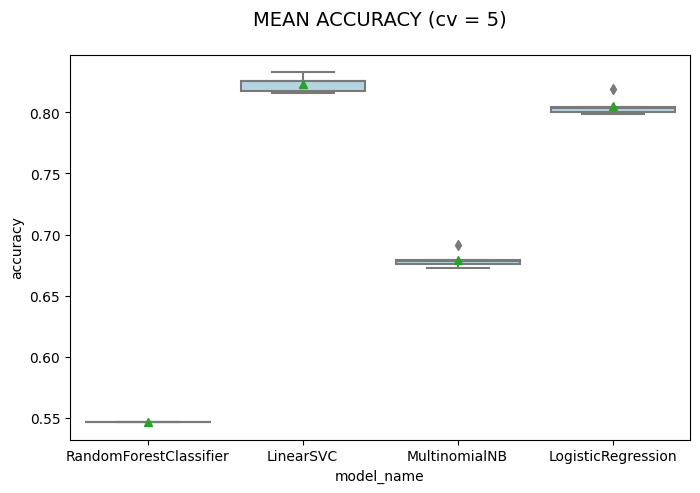

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='model_name', y='accuracy',data=cv_df,color='lightblue', showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=14);

**Model Evaluation**

In [ ]:
#Model Evaluation
from sklearn.metrics import classification_report
X_train, X_test, y_train, y_test,indices_train,indices_test = train_test_split(features, labels,df2.index, test_size=0.25, random_state=0)
model = LinearSVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred.shape

(2500,)

**Precision, Recall, F1-score**

In [ ]:
from sklearn import metrics
print('\t\t\t\tCLASSIFICATIION METRICS\n')
classification_report(y_test, y_pred,labels=np.arange(0,len(df2['Product']),1),target_names=df2['Product'], digits=4,zero_division=0)

				CLASSIFICATIION METRICS



'                                                     precision    recall  f1-score   support\n\n                 Credit reporting, repair, or other     0.8808    0.9394    0.9092      1369\n                 Credit reporting, repair, or other     0.8021    0.8851    0.8415       174\n                 Credit reporting, repair, or other     0.6474    0.7769    0.7063       130\n                                           Mortgage     0.7559    0.7419    0.7488       217\n                        Checking or savings account     0.7716    0.7251    0.7476       382\n                        Credit card or prepaid card     0.6341    0.5200    0.5714        50\n                 Credit reporting, repair, or other     0.7273    0.2051    0.3200        39\n                 Credit reporting, repair, or other     0.7917    0.6230    0.6972        61\n                        Credit card or prepaid card     0.0000    0.0000    0.0000        13\n                 Credit reporting, repair, or other     0

**Confusion Matrix**

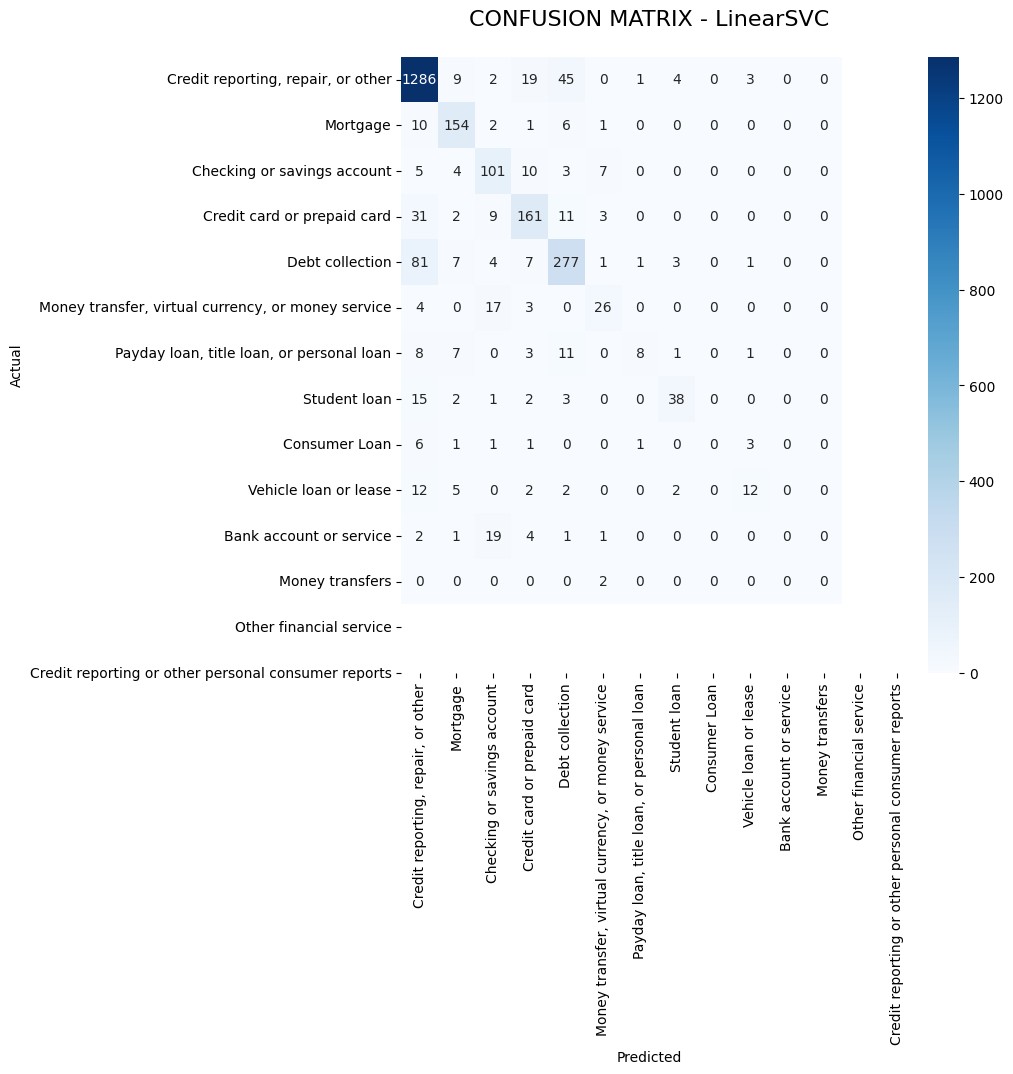

In [ ]:
conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d',
            xticklabels=category_id_df.Product.values,
            yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX - LinearSVC\n", size=16);

**Most correlated terms with each category**

In [ ]:
#Most correlated terms with each category
model.fit(features, labels)

N = 4
for Product, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("\n==> '{}':".format(Product))
  print("  * Top unigrams: %s" %(', '.join(unigrams)))
  print("  * Top bigrams: %s" %(', '.join(bigrams)))


==> 'Bank account or service':
  * Top unigrams: bank, promotion, branch, 2016
  * Top bigrams: xxxx 2015, xx 2016, bank did, checking account

==> 'Checking or savings account':
  * Top unigrams: bank, savings, chime, checking
  * Top bigrams: debit card, savings account, 36 00, overdraft fees

==> 'Consumer Loan':
  * Top unigrams: car, motor, vehicle, acceptance
  * Top bigrams: xxxx 16, report owe, going pay, auto xxxx

==> 'Credit card or prepaid card':
  * Top unigrams: card, amex, purchase, capital
  * Top bigrams: american express, pay balance, missed payment, care credit

==> 'Credit reporting or other personal consumer reports':
  * Top unigrams: 166b, usc, 604, purpose
  * Top bigrams: 166b creditor, 15 usc, xxxx violated, late purpose

==> 'Credit reporting, repair, or other':
  * Top unigrams: equifax, experian, transunion, inquiries
  * Top bigrams: victim identity, xxxx xxxx, experian xxxx, late payments

==> 'Debt collection':
  * Top unigrams: debt, recovery, collecti

**Predictions**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25,random_state = 0)

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5,ngram_range=(1, 2), stop_words='english')

fitted_vectorizer = tfidf.fit(X_train)
tfidf_vectorizer_vectors = fitted_vectorizer.transform(X_train)

model = LinearSVC().fit(tfidf_vectorizer_vectors, y_train)

In [ ]:
new_complaint = """I have been enrolled back at XXXX XXXX University in the XX/XX/XXXX. Recently, i have been harassed by \
Navient for the last month. I have faxed in paperwork providing them with everything they needed. And yet I am still getting \
phone calls for payments. Furthermore, Navient is now reporting to the credit bureaus that I am late. At this point, \
Navient needs to get their act together to avoid me taking further action. I have been enrolled the entire time and my \
deferment should be valid with my planned graduation date being the XX/XX/XXXX."""
print(model.predict(fitted_vectorizer.transform([new_complaint])))

['Student loan']


In [ ]:
df2[df2['Consumer_complaint'] == new_complaint]
print(df2)

                                    Product  \
337270   Credit reporting, repair, or other   
814826   Credit reporting, repair, or other   
1157572  Credit reporting, repair, or other   
589205                             Mortgage   
2863449         Checking or savings account   
...                                     ...   
3409083  Credit reporting, repair, or other   
2756499  Credit reporting, repair, or other   
3392408  Credit reporting, repair, or other   
326256   Credit reporting, repair, or other   
1258628                     Debt collection   

                                        Consumer_complaint  category_id  
337270   The date of my first letter was XXXX. I sent a...            0  
814826   I was XXXX and my ID and social security card ...            0  
1157572  I'm really not sure what happened. I have mail...            0  
589205   I was impacted by hurricane Irma and then Mich...            1  
2863449  I am a XXXX XXXX  XXXX by trade. \n\nAt the en...       

In [ ]:
new_complaint_2 = """Equifax exposed my personal information without my consent, as part of their recent data breach. \
In addition, they dragged their feet in the announcement of the report, and even allowed their upper management to sell \
off stock before the announcement."""
print(model.predict(fitted_vectorizer.transform([new_complaint_2])))

['Credit reporting, repair, or other']


In [ ]:
df2[df2['Consumer_complaint'] == new_complaint_2]
print(df2)

                                    Product  \
337270   Credit reporting, repair, or other   
814826   Credit reporting, repair, or other   
1157572  Credit reporting, repair, or other   
589205                             Mortgage   
2863449         Checking or savings account   
...                                     ...   
3409083  Credit reporting, repair, or other   
2756499  Credit reporting, repair, or other   
3392408  Credit reporting, repair, or other   
326256   Credit reporting, repair, or other   
1258628                     Debt collection   

                                        Consumer_complaint  category_id  
337270   The date of my first letter was XXXX. I sent a...            0  
814826   I was XXXX and my ID and social security card ...            0  
1157572  I'm really not sure what happened. I have mail...            0  
589205   I was impacted by hurricane Irma and then Mich...            1  
2863449  I am a XXXX XXXX  XXXX by trade. \n\nAt the en...       